# 1 Izbira metode in optimizacija hiperparametrov

In [6]:
import pandas as pd
import numpy as np

PODATKI = 'podatki.csv'
RANDOM_SEED = 420

In [7]:
data = pd.read_csv(PODATKI)
print('Število primerov: ', len(data))
features = data.columns[:-1]
data.dtypes

Število primerov:  1203


x1     float64
x2     float64
x3     float64
x4     float64
x5     float64
x6     float64
x7     float64
x8     float64
x9     float64
x10    float64
x11    float64
x12    float64
x13    float64
x14    float64
x15    float64
x16    float64
x17    float64
x18    float64
x19    float64
x20    float64
x21    float64
x22    float64
x23    float64
x24    float64
x25    float64
x26    float64
x27    float64
x28    float64
x29    float64
x30    float64
y       object
dtype: object

Originalni podatki, iz katerih je pridobljen dataset `data`, vsebujejo največ 130 značilk in 2203 primerov.

## 1.1 Ročno

Ročno bomo uporabili random forest. Uporabljam impementacijo `LightGBM` za drevesa in `ray` za hyperoptimizacijo parametrov.

In [8]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test =  train_test_split(data[features], data['y'], test_size=1/4, random_state=RANDOM_SEED)

In [9]:
from ray import tune 

def tune_classifier(config):
    model = LGBMClassifier(**config)
    cv_results = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5)


    mean_roc_auc = np.mean(cv_results)
    
    tune.report(
        mean_roc_auc=mean_roc_auc,
        done=True,
    )

In [14]:
config = {
    "objective": "binary",
    "metric": "binary_error",
    "verbose": -1,
    "boosting_type": "gbdt",
    "num_leaves": tune.randint(5, 100),
    "n_estimators": tune.randint(50, 100),
    "min_child_samples": tune.choice([5, 10, 15, 25, 50,  100, 200]),
    "learning_rate": tune.loguniform(1e-2, 0.05),
}
analysis = tune.run(tune_classifier, resources_per_trial={"cpu": 5}, config=config, num_samples=200, verbose=1, raise_on_failed_trial=False)
results = analysis.dataframe()
results.head()

2023-03-26 17:51:40,293	INFO tune.py:762 -- Total run time: 25.07 seconds (24.75 seconds for the tuning loop).


,mean_roc_auc,done,time_this_iter_s,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,timestamp,...,warmup_time,config/boosting_type,config/learning_rate,config/metric,config/min_child_samples,config/n_estimators,config/num_leaves,config/objective,config/verbose,logdir
0,0.929916,True,0.236337,NaN,NaN,1,0a34f_00000,f57a2e8bbd1e49478637d280a8c3ea0a,2023-03-26_17-51-17,1679845877,...,0.002488,gbdt,0.024031,binary_error,25,66,31,binary,-1,/home/uprimozic/ray_results/tune_classifier_20...
1,0.922630,True,0.108758,NaN,NaN,1,0a34f_00001,e0bdaf34695b46c0a0c68b53d96757fc,2023-03-26_17-51-18,1679845878,...,0.002672,gbdt,0.025232,binary_error,50,72,47,binary,-1,/home/uprimozic/ray_results/tune_classifier_20...
2,0.886253,True,0.238318,NaN,NaN,1,0a34f_00002,7e5eb1ac13674c0994c6172da58dd284,2023-03-26_17-51-18,1679845878,...,0.002466,gbdt,0.011618,binary_error,5,55,68,binary,-1,/home/uprimozic/ray_results/tune_classifier_20...
3,0.902003,True,0.064442,NaN,NaN,1,0a34f_00003,f57a2e8bbd1e49478637d280a8c3ea0a,2023-03-26_17-51-17,1679845877,...,0.002488,gbdt,0.038002,binary_error,200,87,63,binary,-1,/home/uprimozic/ray_results/tune_classifier_20...
4,0.933040,True,0.231814,NaN,NaN,1,0a34f_00004,f57a2e8bbd1e49478637d280a8c3ea0a,2023-03-26_17-51-17,1679845877,...,0.002488,gbdt,0.031142,binary_error,10,50,73,binary,-1,/home/uprimozic/ray_results/tune_classifier_20...


In [17]:
params = results.iloc[0]
params_dict = results.loc[params.name][[col for col in results.columns if col.startswith('config')]].to_dict()
params_dict = {k.replace('config/', ''): v for k, v in params_dict.items()}
# za shranjevanjevanje modela:
# import json
# json.dump(params_dict, open("best_params_trees.json", "w"), indent=2)

# loading:
# params_dict = json.load(open('best_params.json', 'r'))
params_dict

{'boosting_type': 'gbdt',
 'learning_rate': 0.02403066512783489,
 'metric': 'binary_error',
 'min_child_samples': 25,
 'n_estimators': 66,
 'num_leaves': 31,
 'objective': 'binary',
 'verbose': -1}

0.8903654485049833

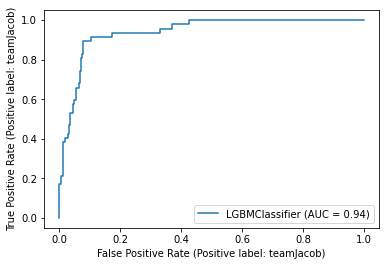

In [27]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

model = LGBMClassifier(**params_dict)
model.fit(X_train, y_train)

RocCurveDisplay.from_estimator(model, X_test, y_test)

## 1.2 Avtomatizirano
Preizkusili bomo drevesa (LightGBM), najbližje sosede in svm. 